In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, sys
from collections import OrderedDict
import pandas as pd
import scipy.stats as st

In [2]:
# navigate to results directory
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# specify path to baseline and tcrp performance results
%cd /content/drive/MyDrive/MBP1413H/tcrp_model/data/results
dataset = 'GDSC'
baseline_path = Path(f"{dataset}/baseline_performances/")
tcrp_path = Path(f"{dataset}/TCRP_performances/")

/content/drive/MyDrive/MBP1413H/tcrp_model/data/results


In [32]:
arr = np.load(f"{tcrp_path}/{drug}/{tissue}/TCRP_performance.npz")
arr["TCRP-fewshot"]

array([0.6967846 , 0.69547364, 0.7002193 , 0.70393274, 0.71006565,
       0.7114212 , 0.71198307, 0.71201882, 0.71152508, 0.7124597 ])

In [33]:
# parse TCRP results 
%%time

results = {}
for outer_directory in tcrp_path.glob("*"): 
    drug = outer_directory.stem
    results[drug] = {}

    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        results[drug][tissue] = {}
        if str(inner_directory).split("/")[-1] != ".ipynb_checkpoints":
          data = np.load(inner_directory / "TCRP_performance.npz")

          for model in ['TCRP']: 
              zero = data[f"{model}-zero"]
              new_data = data["TCRP-fewshot"] 
              fewshot = np.vstack([new_data for _ in range(10)])
              zero = np.vstack([zero for _ in range(10)]) # There is only 1 possible zero-shot, so expanding for all trials
              performance = np.mean(np.hstack([zero, fewshot]), axis=0)
              results[drug][tissue][model] = performance    


CPU times: user 12.2 ms, sys: 2.69 ms, total: 14.9 ms
Wall time: 32 ms


In [34]:
# parse baseline results 
%%time

for outer_directory in baseline_path.glob("*"): 
    drug = outer_directory.stem
    
    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        data = np.load(inner_directory / "baseline_performance.npz")
        
        for model in ['Linear Regression', 'Nearest Neighbour', 'Random Forest','Neural Network']: 
          zero = data[f"{model}-zero"]
          zero = np.vstack([zero for _ in range(20)]) # There is only 1 possible zero-shot, so expanding for all trials
          performance = np.median(np.hstack([zero, data[f"{model}-fewshot"]]), axis=0)
            
          results[drug][tissue][model] = performance    

CPU times: user 37.9 ms, sys: 2.65 ms, total: 40.5 ms
Wall time: 56.5 ms


In [35]:
for i in results:
    remove_key = results[i].pop(".ipynb_checkpoints", None)
results

{'GSK429286A': {'urinary_tract': {'TCRP': array([-0.4570978 ,  0.56274712,  0.5633222 ,  0.56320469,  0.56260581,
           0.56289472,  0.56324717,  0.56296363,  0.56304056,  0.56305156,
           0.5634083 ]),
   'Linear Regression': array([0.51106818, 0.57141684, 0.5678316 , 0.57412301, 0.58476518,
          0.58154869, 0.58786925, 0.59290052, 0.56994307, 0.56298822,
          0.56830085]),
   'Nearest Neighbour': array([0.12569472, 0.12182541, 0.12182541, 0.17817537, 0.20560243,
          0.21875346, 0.2273934 , 0.26647056, 0.293557  , 0.31243547,
          0.31536483]),
   'Random Forest': array([0.53741621, 0.58726919, 0.55164982, 0.4922935 , 0.57193523,
          0.50340628, 0.54691942, 0.55873626, 0.55025149, 0.53450037,
          0.57578078]),
   'Neural Network': array([0.17153116, 0.22728415, 0.22728415, 0.22728415, 0.22728415,
          0.22728415, 0.22728415, 0.22728415, 0.22728415, 0.22728415,
          0.22728415])},
  'skin': {'TCRP': array([0.04231789, 0.37470771, 0.

In [52]:
drug = "GSK429286A"
tissue = "liver"
res_drug = dict(results[drug])
res_drug_tissue = res_drug[tissue]

In [53]:
import itertools


flipped_results = dict([(x, dict([(k, results[k][x]) for k,v in results.items() if x in results[k]])) 
for x in set(itertools.chain(*[z for z in results.values()]))])

In [54]:
results_by_baseline = {'Linear Regression': [], 'Nearest Neighbour': [], 'Random Forest': [],'Neural Network': [], 'TCRP': []}

#res = flipped_results
#res = results
#res = res_drug
res = res_drug_tissue

'''
for drug, d in res.items(): 
    for tissue, d in d.items(): 
        for model, p in d.items(): 
            results_by_baseline[model].append(p)
'''
#'''
for tissue, d in res_drug.items():
    for model, p in d.items(): 
        results_by_baseline[model].append(p)
'''
for model, p in res_drug_tissue.items(): 
        results_by_baseline[model].append(p)
'''           
for model, ps in results_by_baseline.items(): 
    results_by_baseline[model] = np.vstack(ps)


In [55]:
def get_statistics(data): 
    median = np.nanmean(data, axis=0)
    stdev = np.nanstd(data, axis=0)
    index = np.random.choice(data.shape[0], size=(data.shape[0], 1000), replace=True)
    resampled = np.nanmean(data[index], axis=0)

    low = np.nanpercentile(resampled, 2.5, axis=0)
    high = np.nanpercentile(resampled, 97.5, axis=0)
    
    ci = np.vstack([median - low, high-median])
    
    return median, stdev, ci

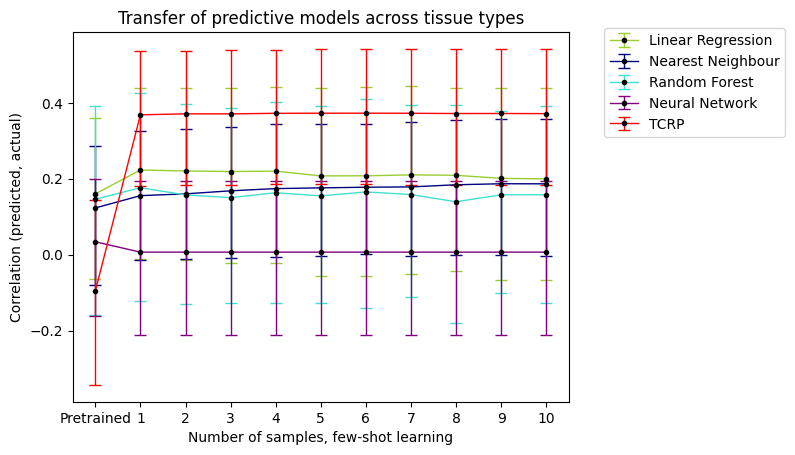

In [56]:
fig, ax = plt.subplots()
x = np.arange(11)
kwargs = {'capsize': 4}

color_dict={"TCRP":"red",
            "Random Forest":"turquoise",
            "Neural Network":"purple",
            "Nearest Neighbour": "navy",
            "Linear Regression":"yellowgreen"}

for model, ps in results_by_baseline.items(): 
    median, std, yerr = get_statistics(ps)
    ax.errorbar(x, median, yerr=yerr, label=model, color=color_dict[model],marker='o', 
                ms = 3, mfc = "black", mec ="black", lw = 1,**kwargs)

ax.legend()
labels = ['Pretrained'] + [str(i) for i in range(1, 11)]
ax.set_xticks(x)
ax.set_xticklabels(labels)

#ax.set_ylim([0, 0.3])
ax.set_xlabel("Number of samples, few-shot learning")
ax.set_ylabel("Correlation (predicted, actual)")
ax.set_title("Transfer of predictive models across tissue types")
ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.03), numpoints=1)

In [41]:
res_drug_tissue

{'TCRP': array([0.19213307, 0.112396  , 0.13409477, 0.14101607, 0.16429129,
        0.16085184, 0.16083616, 0.1656177 , 0.16443268, 0.17010668,
        0.17221253]),
 'Linear Regression': array([0.03407327, 0.02941059, 0.02644179, 0.02307749, 0.02600607,
        0.02240688, 0.02598717, 0.02905821, 0.03259724, 0.02446747,
        0.02407535]),
 'Nearest Neighbour': array([0.15873895, 0.16439068, 0.16204509, 0.1583779 , 0.15233167,
        0.15233167, 0.1422175 , 0.14424568, 0.14324205, 0.1444594 ,
        0.1444594 ]),
 'Random Forest': array([0.22280206, 0.18704247, 0.20655333, 0.22918258, 0.19751522,
        0.20138779, 0.20454403, 0.22581625, 0.20511968, 0.19342952,
        0.20586587]),
 'Neural Network': array([-0.00582081, -0.00607929, -0.00607929, -0.00607929, -0.00607929,
        -0.00607929, -0.00607929, -0.00607929, -0.00607929, -0.00607929,
        -0.00607929])}

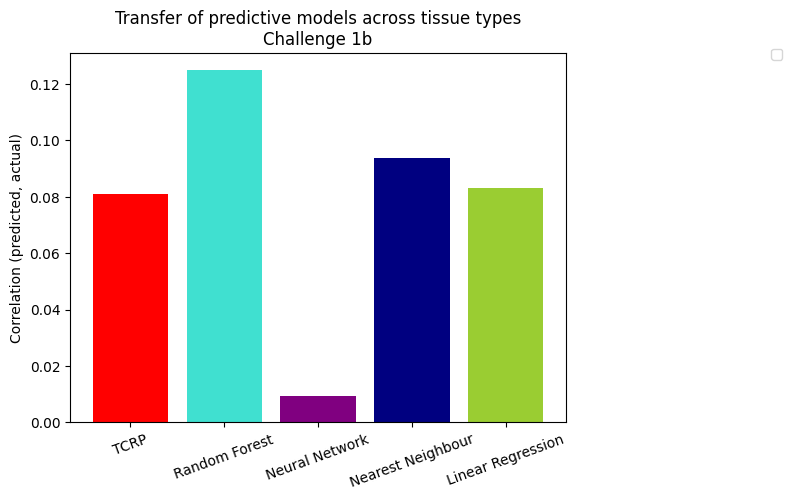

In [ ]:
fig, ax = plt.subplots()
x = np.arange(11)
kwargs = {'capsize': 4}

color_dict={"TCRP":"red",
            "Random Forest":"turquoise",
            "Neural Network":"purple",
            "Nearest Neighbour": "navy",
            "Linear Regression":"yellowgreen"}

plt_dict = {}

vec = ["TCRP","Random Forest","Neural Network","Nearest Neighbour","Linear Regression"]
for model1 in vec:
  for model2, ps in results_by_baseline.items(): 
    median, std, yerr = get_statistics(ps)
    if(model1 == model2):
      ax.bar(model1, median[0], color=color_dict[model1])

ax.legend()

#ax.set_ylim([0, 0.3])
plt.xticks(rotation=20)
ax.set_ylabel("Correlation (predicted, actual)")
ax.set_title("Transfer of predictive models across tissue types\nChallenge 1b")
ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1.03), numpoints=1)

In [ ]:
def prepare_points(model_dict):
  items = model_dict.items()
  myList = (items) 
  y,x = zip(*myList) 
  return y,x

In [ ]:

flipped_results.items()

dict_items([('stomach', {'GSK429286A': {'TCRP': array([-0.71143407,  0.64518955,  0.64613968,  0.64431696,  0.64505593,
        0.64491959,  0.64358936,  0.64356604,  0.64289743,  0.64319465,
        0.64334594]), 'Linear Regression': array([0.45027819, 0.51850886, 0.51837255, 0.5209034 , 0.52226053,
       0.52453323, 0.52444425, 0.524021  , 0.52512176, 0.52365584,
       0.52348403]), 'Nearest Neighbour': array([0.42721252, 0.52656814, 0.52656814, 0.52656814, 0.52656814,
       0.52656814, 0.52656814, 0.52656814, 0.52656814, 0.52656814,
       0.52656814]), 'Random Forest': array([0.51252848, 0.51876926, 0.51406808, 0.50739632, 0.48484757,
       0.52723473, 0.52039997, 0.52356336, 0.50868418, 0.4782787 ,
       0.47977427]), 'Neural Network': array([-0.41766596, -0.49585331, -0.49585331, -0.49585331, -0.49585331,
       -0.49585331, -0.49585331, -0.49585331, -0.49585331, -0.49585331,
       -0.49585331])}}), ('pleura', {'TW_37': {'TCRP': array([-0.0631531 ,  0.4034451 ,  0.40307988,

In [ ]:
TCRP_tissue = {}
linear_tissue = {}
RF_tissue = {}
KNN_tissue = {}
NN_tissue = {}

for tissue, d in flipped_results.items(): # key = tissue; value = performance of prediction for each drug
  for drug, r in d.items(): 
      #if False in np.isnan(results[key][dataset]["Nearest Neighbour"]):
      #   p = np.nan_to_num(results[key][dataset]["Nearest Neighbour"])
    #print(r["Linear Regression"])
    TCRP_tissue[tissue] = np.mean(r["TCRP"])
    linear_tissue[tissue] = np.mean(r["Linear Regression"])
    RF_tissue[tissue] = np.mean(r["Random Forest"])
    NN_tissue[tissue] = np.mean(r["Neural Network"])
    KNN_tissue[tissue] = np.mean(r["Nearest Neighbour"])


In [ ]:
{k: v for k, v in sorted(TCRP_tissue.items(), key=lambda item: item[1])}

TypeError: ignored

In [ ]:
TCRP_tissue = {k: v for k, v in sorted(TCRP_tissue.items(), key=lambda item: item[1])}   
linear_tissue = dict(OrderedDict((k, linear_tissue[k]) for k in list(TCRP_tissue.keys())))
NN_tissue = dict(OrderedDict((k, NN_tissue[k]) for k in list(TCRP_tissue.keys())))
RF_tissue = dict(OrderedDict((k, RF_tissue[k]) for k in list(TCRP_tissue.keys())))
KNN_tisse = dict(OrderedDict((k, KNN_tissue[k]) for k in list(TCRP_tissue.keys())))

TypeError: ignored

In [ ]:
TCRP_y,TCRP_x = prepare_points(TCRP_tissue)

linear_y,linear_x = prepare_points(linear_tissue)
RF_y,RF_x = prepare_points(RF_tissue)
KNN_y,KNN_x = prepare_points(KNN_tissue)
NN_y,NN_x = prepare_points(NN_tissue)

Text(0.5, 1.0, 'Transfer of predictive models across tissue types')

<Figure size 640x480 with 0 Axes>

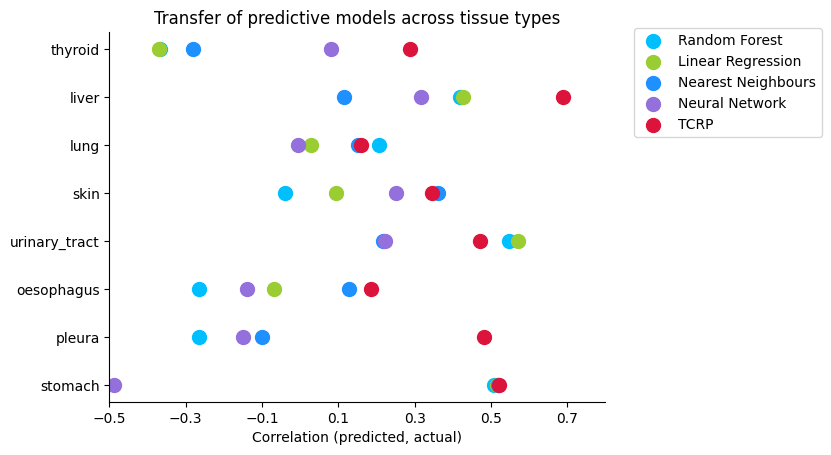

In [ ]:
fig = plt.figure()


fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#fig.set_size_inches(8,12)

RF = plt.scatter(RF_x,RF_y,color="deepskyblue",s=100)
RF.set_label("Random Forest")
linear = plt.scatter(linear_x, linear_y,color="yellowgreen",s=100)
linear.set_label("Linear Regression")
KNN = plt.scatter(KNN_x, KNN_y,color="dodgerblue",s=100)
KNN.set_label("Nearest Neighbours")
NN = plt.scatter(NN_x,NN_y,color="mediumpurple",s=100)
NN.set_label("Neural Network")
TCRP = plt.scatter(TCRP_x,TCRP_y,color="crimson",s=100)
TCRP.set_label("TCRP")
plt.xlabel("Correlation (predicted, actual)")
plt.xlim(-0.5,0.8)
plt.xticks([-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7])
#plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.03))
plt.title("Transfer of predictive models across tissue types")